# Stroke Prediction using Support Vector Machines

### GOAL:
I want to be able to determine if certain uncommon factors (different than the usual ones such as hypertension, heart disease, diabetes, smoking, obesity, and a family history of stroke) can be predictive (using SVM's) of whether someone has a stroke or not. These uncommon factors that I will be isolating include whether someone drinks unhealthy beverages, eats fruits and vegetables, and demographics such as their sex, poverty, marital status, and height. 

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from ISLP.svm import plot as plot_svm

In [4]:
df = pd.read_csv('nhis_2022.csv')

In [6]:
df.head(), df.shape

(   YEAR  SERIAL  STRATA  PSU         NHISHID  REGION  PERNUM  \
 0  2022       1     143   16  0002022H000001       4       1   
 1  2022       2     106   53  0002022H000003       3       1   
 2  2022       2     106   53  0002022H000003       3       2   
 3  2022       3     134   13  0002022H000006       2       1   
 4  2022       4     106   53  0002022H000007       3       1   
 
             NHISPID      HHX  SAMPWEIGHT  ...  TOMSAUCEMNO  SODAPNO  FRIESPNO  \
 0  0002022H00000110  H000001      8018.0  ...            2        0       110   
 1  0002022H00000310  H000003     10117.0  ...            1        0         1   
 2  0002022H00000320  H000003      7933.0  ...          996      996       996   
 3  0002022H00000610  H000006      2681.0  ...            1        1         1   
 4  0002022H00000710  H000007     10233.0  ...            3       30         5   
 
    SPORDRMNO  FRTDRINKMNO  COFETEAMNO  POTATONO  PIZZANO  HRSLEEP  CVDSHT  
 0          3            0           

In [8]:
df.isna().sum() # check for NaNs

YEAR           0
SERIAL         0
STRATA         0
PSU            0
NHISHID        0
REGION         0
PERNUM         0
NHISPID        0
HHX            0
SAMPWEIGHT     0
ASTATFLG       0
CSTATFLG       0
AGE            0
SEX            0
MARSTCUR       0
EDUC           0
HOURSWRK       0
POVERTY        0
HEIGHT         0
WEIGHT         0
BMICALC        0
HINOTCOVE      0
CANCEREV       0
CHEARTDIEV     0
DIABETICEV     0
HEARTATTEV     0
STROKEV        0
ALCANYNO       0
ALCDAYSYR      0
CIGDAYMO       0
MOD10DMIN      0
VIG10DMIN      0
FRUTNO         0
VEGENO         0
JUICEMNO       0
SALADSNO       0
BEANNO         0
SALSAMNO       0
TOMSAUCEMNO    0
SODAPNO        0
FRIESPNO       0
SPORDRMNO      0
FRTDRINKMNO    0
COFETEAMNO     0
POTATONO       0
PIZZANO        0
HRSLEEP        0
CVDSHT         0
dtype: int64

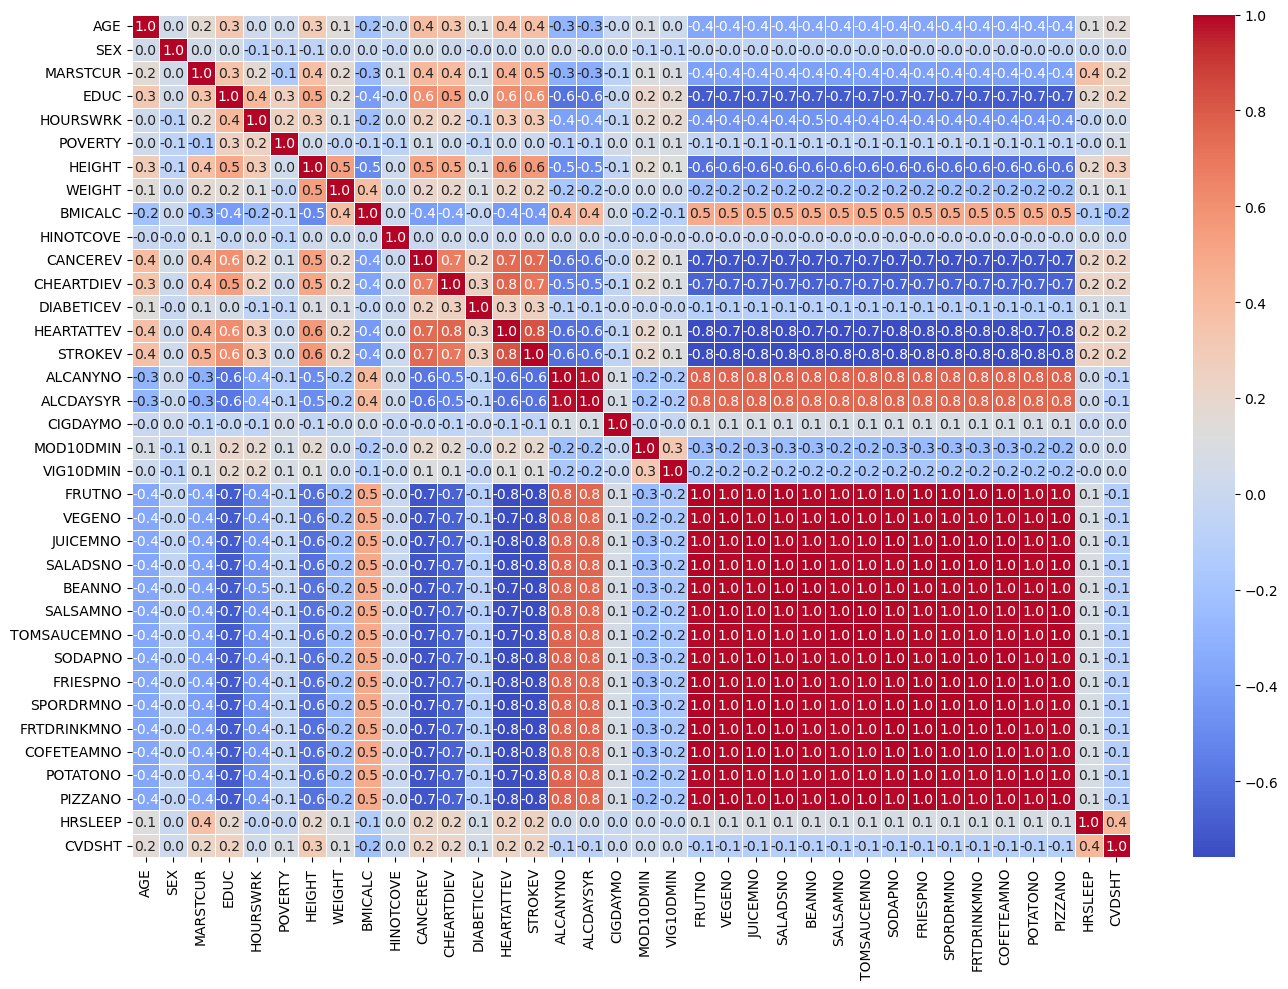

In [10]:
# Checking for high correlations so that I can see if variables are equally predictive
# Goal: want to reduce the amount of variables as features
df_cut = df.iloc[:, 12:] # Cut the variables indicated as not required ("can largely ignore these for this homework")
corr = df_cut.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, fmt=".1f", linewidths=0.5, cmap='coolwarm')
plt.tight_layout()
plt.show()

In [11]:
# Want to predict those that are more at risk for strokes
# Filter for above the age of 45, which is an arbitrary number that I have intuitively chosen for filtering
df_age = df[df['AGE'] >= 45].copy()

In [12]:
# Check to see the count distribution for the predictor variable
# Want to know how to clean the variable if required
df_age['STROKEV'].value_counts(normalize=True)

STROKEV
1    0.943987
2    0.053970
7    0.001135
9    0.000908
Name: proportion, dtype: float64

In [13]:
# Filter for 1's and 2's (1: No, 2: Yes)
# Based on the codebook, 7's and 9's will not be helpful (essentially they are NaNs)
# Also, their percentage of the distribution is negligibly small, so I will drop them
df_age_stroke = df_age[df_age['STROKEV'].isin([1, 2])]

# Variable Creation

Using the information from the correlations, I will combine some variables into their own features for efficiency. For example, I want to see if combining the alcohol-related variables can be done, and/or if the consumption of fruits and vegetables, and the consumption of unhealthy beverages can be done. But first, I will check the specific values of each variable and what they mean, e.g., in the FRUTNO column, 996 means "Not in Universe". This section will be to thoroughly check these values and their associated meaning.

### Habit Variables

In [18]:
df_age_stroke.shape[0] # for comparison of the NaNs (e.g., counts of 996's)

17585

In [20]:
# Check the NaN-style values in both fruit and vegetable columns
df_age_stroke['FRUTNO'].isin([996,997, 998, 999]).sum(), df_age_stroke['VEGENO'].isin([996,997, 998, 999]).sum()

(627, 660)

In [22]:
# Check how many values are "Not in Universe" 
df_age_stroke['VIG10DMIN'].isin([000]).sum(), df_age_stroke['MOD10DMIN'].isin([000]).sum()

(13035, 6169)

Cannot use VIG10DMIN and MOD10DMIN because '000' means "Not in Universe" but Pandas DataFrames is handling these as 0's instead of 000. As a result, the meanings of "0 minutes of exercise" is coinsiding with "Not in Universe".

In [25]:
# Check the unhealthy beverages for their NaN-style values
df_age_stroke['SODAPNO'].isin([996,997,998,999]).sum(), df_age_stroke['SPORDRMNO'].isin([996,997,998,999]).sum(), df_age_stroke['FRTDRINKMNO'].isin([996,997,998,999]).sum()

(600, 601, 614)

In [27]:
# Check the NaN's in the hours slept variable
df_age_stroke['HRSLEEP'].isin([0, 97, 98, 99]).sum()

571

In [29]:
# Check the alcohol-related variables for NaNs
df_age_stroke['ALCANYNO'].isin([996,997,998,999]).sum(), df_age_stroke['ALCDAYSYR'].isin([996,997,998,999]).sum()

(2487, 2490)

Will not use alcohol-related variables because there are a lot of values that would be NaNs, hence, dropping them would remove too many observations. After the preliminary cleaning, I will re-check to see how many NaNs there are in these columns to re-assess.

In [32]:
# Isolate all the bad rows that contain these NaN-style values
# Want to remove their influence so that scaling the data is meaningful
bad_rows_habits = (
    df_age_stroke['FRUTNO'].isin([996, 997, 998, 999]) |
    df_age_stroke['VEGENO'].isin([996, 997, 998, 999]) |
    df_age_stroke['SODAPNO'].isin([996, 997, 998, 999]) |
    df_age_stroke['SPORDRMNO'].isin([996, 997, 998, 999]) |
    df_age_stroke['FRTDRINKMNO'].isin([996, 997, 998, 999])
)

# Remove the NaN-styled values
df_age_stroke_cleaned = df_age_stroke[~bad_rows_habits].copy()

In [34]:
df_age_stroke.shape[0], df_age_stroke_cleaned.shape[0] # before and after cleaning

(17585, 16864)

In [36]:
# Check again the amount of NaNs in the alcohol-related variables to determine if they could be dropped after cleaning
df_age_stroke_cleaned['ALCANYNO'].isin([996,997,998,999]).sum(), df_age_stroke_cleaned['ALCDAYSYR'].isin([996,997,998,999]).sum()

(1986, 1987)

There are still too many NaNs, so I will proceed by not using the alcohol-related variables.

### Demographic Variables

In [38]:
df_age_stroke_cleaned.shape[0] # Counts of observations

16864

In [40]:
# Check for NaN-type values in Poverty (i.e., 98: Undefinable, 99: Unknown)
df_age_stroke_cleaned['POVERTY'].isin([98,99]).sum()

0

In [42]:
# Check for NaN-type values in Marital Status (i.e., 0: Not in Universe, 9: Unknown Marital Status)
df_age_stroke_cleaned['MARSTCUR'].isin([0,9]).sum()

131

In [44]:
# Check for NaN-type values in Height
# (i.e., 95: Unknown, 95: Unknown Marital Status, 97: Unknown-refused, 98: Unknown-not ascertained, 99: Unknown-don't know)
df_age_stroke_cleaned['HEIGHT'].isin([95,97,98,99]).sum()

46

In [46]:
# Check for NaN-type values in Sex 
# (i.e., 7: Unknown-refused, 8: Unknown-not ascertained, 9: Unknown-not known)
df_age_stroke_cleaned['SEX'].isin([7,8,9]).sum()

1

In [48]:
# Get the rows where NaN values are found in the demographic variables
# Want to remove their influence when scaling the data for model fitting
bad_rows_demo = (
    df_age_stroke_cleaned['POVERTY'].isin([98,99]) |
    df_age_stroke_cleaned['MARSTCUR'].isin([0,9]) |
    df_age_stroke_cleaned['HEIGHT'].isin([95,97,98,99]) |
    df_age_stroke_cleaned['SEX'].isin([7,8,9])
)

# Remove these NaN values
df_age_stroke_cleaned_2 = df_age_stroke_cleaned[~bad_rows_demo].copy()

In [50]:
df_age_stroke_cleaned.shape[0], df_age_stroke_cleaned_2.shape[0] # before and after 2nd cleaning

(16864, 16692)

In [52]:
100 * (1 - df_age_stroke_cleaned_2.shape[0] / df_age_stroke.shape[0]) # Percentage of observations lost after cleaning

5.078191640602792

### Reasoning for dropping these NaNs:
Instead of having to distinguish the different meanings of the varying NaN-style values, i.e., how to encode the numerical meaning of Unknown-refused versus Unknown-not ascertained in the context of the meaning of the other numbers in their respected columns (what numerical value provides meaning to 'Unknown-refused' in the context of the 'Sex' demographic?), it is easier to drop all of these NaN-style values since the total count of them is just over 5%. 

### Setting up features and target

In [56]:
# Combine common correlated variables 
df_age_stroke_cleaned_2['FRUIT_VEG_CONSUMP'] = df_age_stroke_cleaned_2['FRUTNO'] + df_age_stroke_cleaned_2['VEGENO']
df_age_stroke_cleaned_2['SUGARY_BEV_CONSUMP'] = df_age_stroke_cleaned_2['SODAPNO'] + df_age_stroke_cleaned_2['SPORDRMNO'] + df_age_stroke_cleaned_2['FRTDRINKMNO']

In [58]:
# Gather demographic and habit variables for the feature set
demo_vars = df_age_stroke_cleaned_2[['POVERTY', 'HEIGHT', 'MARSTCUR', 'SEX']].copy()
habit_vars = df_age_stroke_cleaned_2[['FRUIT_VEG_CONSUMP', 'SUGARY_BEV_CONSUMP']].copy()

In [115]:
# Set the target variable to binary
# 0: No stroke, 1: Ever told had a stroke
y = df_age_stroke_cleaned_2['STROKEV'].map({1: 0, 2: 1}).reset_index(drop=True)

In [62]:
# Map binary value of sex to 0's and 1's
demo_vars['SEX'] = demo_vars['SEX'].map({1: 0, 2: 1}) # 0: Male, 1: Female

# One-hot encode Marital Status
demo_vars_encoded = pd.get_dummies(demo_vars, columns=['MARSTCUR']).astype(int)

In [64]:
demo_vars_encoded.head() # print to observe the new columns created after the one-hot encoding

,POVERTY,HEIGHT,SEX,MARSTCUR_1,MARSTCUR_2,MARSTCUR_3,MARSTCUR_4,MARSTCUR_5,MARSTCUR_6,MARSTCUR_7,MARSTCUR_8
0,34,69,0,1,0,0,0,0,0,0,0
3,31,75,0,0,0,0,0,1,0,0,0
4,32,71,0,1,0,0,0,0,0,0,0
6,36,71,0,1,0,0,0,0,0,0,0
8,33,68,0,0,0,0,0,0,0,1,0


In [66]:
# Rename marital columns
demo_vars_encoded = demo_vars_encoded.rename(columns={
    'MARSTCUR_1': 'MarriedSpousePresent',
    'MARSTCUR_2': 'MarriedSpouseAbsent',
    'MARSTCUR_3': 'MarriedSpouseUnknown',
    'MARSTCUR_4': 'Separated',
    'MARSTCUR_5': 'Divorced',
    'MARSTCUR_6': 'Widowed',
    'MARSTCUR_7': 'LivingWithPartner',
    'MARSTCUR_8': 'NeverMarried'
})

In [68]:
demo_vars_encoded.head() # Check to see if properly done

,POVERTY,HEIGHT,SEX,MarriedSpousePresent,MarriedSpouseAbsent,MarriedSpouseUnknown,Separated,Divorced,Widowed,LivingWithPartner,NeverMarried
0,34,69,0,1,0,0,0,0,0,0,0
3,31,75,0,0,0,0,0,1,0,0,0
4,32,71,0,1,0,0,0,0,0,0,0
6,36,71,0,1,0,0,0,0,0,0,0
8,33,68,0,0,0,0,0,0,0,1,0


In [70]:
# Assign the feature matrix
X = pd.concat([demo_vars_encoded, habit_vars], axis=1).reset_index(drop=True)

In [72]:
# Scale the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Assign it back to a dataframe since scaler transforms it into NumPy array
X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

In [74]:
X.head() # last check before fitting begins

,POVERTY,HEIGHT,SEX,MarriedSpousePresent,MarriedSpouseAbsent,MarriedSpouseUnknown,Separated,Divorced,Widowed,LivingWithPartner,NeverMarried,FRUIT_VEG_CONSUMP,SUGARY_BEV_CONSUMP
0,0.419197,0.097566,-1.118124,1.063350,-0.168342,-0.01731,-0.125543,-0.478329,-0.428852,-0.195750,-0.349501,1.160552,0.037524
1,0.032274,0.858820,-1.118124,-0.940425,-0.168342,-0.01731,-0.125543,2.090611,-0.428852,-0.195750,-0.349501,-0.345029,0.037524
2,0.161249,0.351317,-1.118124,1.063350,-0.168342,-0.01731,-0.125543,-0.478329,-0.428852,-0.195750,-0.349501,-0.156831,4.645518
3,0.677146,0.351317,-1.118124,1.063350,-0.168342,-0.01731,-0.125543,-0.478329,-0.428852,-0.195750,-0.349501,-0.439128,1.354094
4,0.290223,-0.029309,-1.118124,-0.940425,-0.168342,-0.01731,-0.125543,-0.478329,-0.428852,5.108562,-0.349501,-0.627326,-0.291618


### Fitting the Linear SVM

In [119]:
# Split into train and test sets using stratify to ensure balancing of the target variable across splittings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1337, stratify = y)

One important note is that the data is heavily imbalanced for the stroke class (95% of the data is for people who haven't had a stroke while 5% are for those who have had a stroke), so it will be highly unlikely that a good result will be acquired. This is because a support vector machine tries to minimize an equation that will determine that it is "cheaper" to misclassify all of the 5% to get 95% correct. Basically, it is easier to just get the 5% wrong and to get the 95% right to get the "best" score. As a result, I will set the class weight to be 'balanced' so that penalties on stroke cases are more expensive than on non-strokes, forcing the model to move the decision boundary to catch some positives at the cost of some more false positives.

In [121]:
svm_lin = SVC(class_weight='balanced', kernel='linear')

param_grid_lin = {
    'C': [0.001, 0.005, 0.01, 0.1, 0.5, 1]
}

grid_lin = GridSearchCV(
    svm_lin,
    param_grid=param_grid_lin,
    cv=5,
    scoring='roc_auc', # use AUC because it handles class imbalances nicely
    n_jobs=-1,
    verbose=1
)
grid_lin.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', kernel='linear'),
             n_jobs=-1, param_grid={'C': [0.001, 0.005, 0.01, 0.1, 0.5, 1]},
             scoring='roc_auc', verbose=1)

In [122]:
grid_lin.best_params_, grid_lin.best_score_

({'C': 0.005}, 0.6537811929516403)

In [123]:
print(classification_report(y_test, grid_lin.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79      3161
           1       0.09      0.55      0.15       178

    accuracy                           0.67      3339
   macro avg       0.53      0.61      0.47      3339
weighted avg       0.92      0.67      0.76      3339



### Fitting the radial SVM

In [124]:
svm_rbf = SVC(class_weight='balanced', kernel='rbf')

param_grid_rbf = {
    'C': [0.01, 0.1, 0.5, 1, 2, 3],
    'gamma': [0.001, 0.01, 0.1, 1]
}

grid_rbf = GridSearchCV(
    svm_rbf,
    param_grid=param_grid_rbf,
    cv=5,
    scoring='roc_auc', # use AUC because it handles class imbalances nicely
    n_jobs=-1,
    verbose=1
)
grid_rbf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 2, 3],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             scoring='roc_auc', verbose=1)

In [133]:
grid_rbf.best_params_, grid_rbf.best_score_

({'C': 3, 'gamma': 0.001}, 0.6516638984988896)

In [135]:
print(classification_report(y_test, grid_rbf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.64      0.77      3161
           1       0.08      0.55      0.14       178

    accuracy                           0.64      3339
   macro avg       0.52      0.60      0.46      3339
weighted avg       0.92      0.64      0.74      3339



In [107]:
# I cannot fit a grid_rbf to the plot to get the support vectors
# so I will fit a new model for plotting
svm_rbf_plot = SVC(C=3, gamma = 0.001, class_weight='balanced', kernel='rbf')
svm_rbf_plot.fit(X_train, y_train)

SVC(C=3, class_weight='balanced', gamma=0.001)

C:\Users\stefa\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\stefa\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\stefa\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


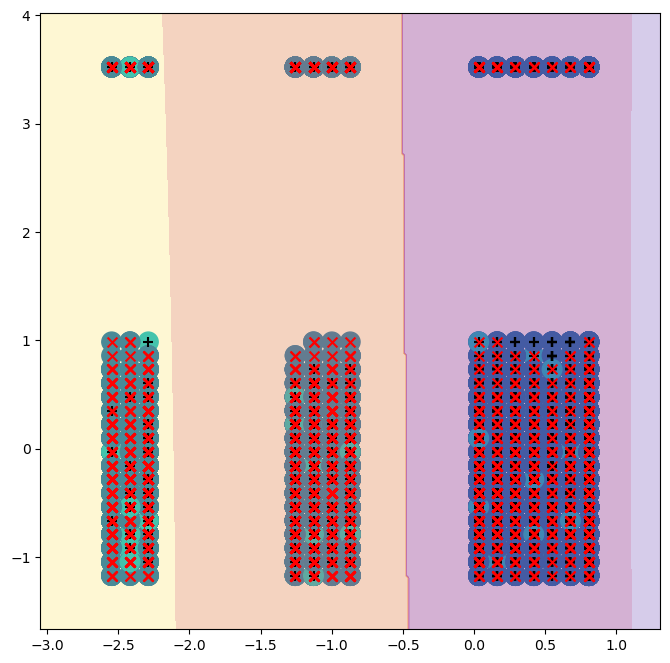

In [111]:
# Plot the first two features
X_plot = X_train.values
y_plot = y_train.values

fig, ax = plt.subplots(figsize=(8,8))
plot_svm(X_plot,
         y_plot,
         svm_rbf_plot,
         ax=ax)

The horizontal and vertical axes are the first two features (Poverty and Height) of the X_train dataframe. The thin bands where the colors are changing are the decision boundaries. More specifically, there are three bands, two of which are the +-1 margin bands and the center one is the decision boundary. 

### Fitting the poly SVM

In [137]:
# degree is set to 2 since running a grid search on my computer crashes when there are multiple values for degree
svm_poly = SVC(degree = 2, class_weight='balanced', kernel='poly')

param_grid_poly= {
    'C': [0.005, 0.01, 0.1, 0.5],
    'gamma': [0.01, 0.1, 1]
}

grid_poly = GridSearchCV(
    svm_poly,
    param_grid=param_grid_poly,
    cv=5,
    scoring='roc_auc', # use AUC because it handles class imbalances nicely
    n_jobs=-1,
    verbose=1
)
grid_poly.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=SVC(class_weight='balanced', degree=2, kernel='poly'),
             n_jobs=-1,
             param_grid={'C': [0.005, 0.01, 0.1, 0.5], 'gamma': [0.01, 0.1, 1]},
             scoring='roc_auc', verbose=1)

In [138]:
grid_poly.best_params_, grid_poly.best_score_

({'C': 0.5, 'gamma': 1}, 0.605508419932731)

In [139]:
print(classification_report(y_test, grid_poly.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82      3161
           1       0.09      0.51      0.15       178

    accuracy                           0.70      3339
   macro avg       0.53      0.61      0.48      3339
weighted avg       0.92      0.70      0.78      3339



### Conclusions

Interestingly, the polynomial kernel slightly outperformed the RBF kernel on the test set. This could be because the relationship between the features and stroke outcome was somewhat close to linear or low degree polynomial. The linear model was not far behind in accuracy, thus implying that a lot of the signal was capturable via a roughly linear decision function. It’s worth noting that with different features, since uncommon ones were used, the predictive accuracy of someone being told that they have a stroke would go up. Therefore, this experiment concludes that these uncommon features were only somewhat predictive because they provide results greater than chance. So none of them were illuminating in determining if someone were to have a stroke or not.